In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [2]:
import statistics as s
from collections import Counter, deque
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

class FinalSelection(State):
    
    def __init__(self, state):
        self.state = state
    
    @property
    def log(self):
        return []
    
    @property
    def dot(self):
        result = ["digraph G {", '  rankdir="RL";', ""]
        actions = Counter()

        stack = deque([self.state])
        visited = {id(self.state)}
        while stack:
            current = stack.popleft()
            current.final_selected = {
                work for work in current.related 
                if int(getattr(work, "final_selected", 0))
            }
            current.seed_set = {
                work for work in current.related 
                if int(getattr(work, "seed_set", 0))
            }
            current.delta_selected = {}
            current.delta_seed_set = {}
            options = [
                ("visited", len(current.visited)),
                ("WorkSnowball", len(current.related)),
                ("selected", len(current.final_selected)),
                ("seed_set", len(current.seed_set)),
            ]
            result.append('  {0} [label="{0}\\n{1}"];'.format(
                current.name, 
                "\\n".join("{}: {}".format(key, value) for key, value in options)
            ))
            if current.previous:
                operation = current.previous[1]
                for element in current.previous[0]:
                    if operation == "union":
                        result.append('  {} -> {} [label="{}"];'.format(
                            current.name, element.name, operation
                        ))
                        
                        
                    else:
                        current.delta_selected = {
                            work for work in current.delta_related 
                            if int(getattr(work, "final_selected", 0))
                        }
                        current.delta_seed_set = {
                            work for work in current.delta_related 
                            if int(getattr(work, "seed_set", 0))
                        }
                        
                        options = [
                            ("found", len(current.delta_visited)),
                            ("WorkSnowball", len(current.delta_related)),
                            ("selected", len(current.delta_selected)),
                            ("seed_set", len(current.delta_seed_set)),
                        ]
                        result.append('  {} -> {} [label="{}\\n{}"];'.format(
                            current.name, element.name, operation,
                            "\\n".join("{}: {}".format(key, value) for key, value in options)
                        ))
                    if id(element) not in visited:
                        stack.append(element)
                        visited.add(id(element))
            result.append("")

        result.append("}")
        return '\n'.join(result)


def precision_recall(state, total, final, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "fmeasure", 
        "final_precision", "final_recall", "final_fmeasure", 
        "operation", "delta_related", "delta_visited", "delta_selected",
        "related", "visited", "final_selected",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure",
        "final_accumulated_precision", "final_accumulated_recall", "final_accumulated_fmeasure"
    ]]
    FinalSelection(state).dot
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        final_accumulated_recall = len(current.final_selected) / len(final)
        final_recall = len(current.delta_selected) / len(final)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            final_accumulated_precision = len(current.final_selected) / len(current.visited)
            final_precision = len(current.delta_selected) / len(current.delta_visited)
        except ZeroDivisionError:
            final_precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
        try:
            final_accumulated_fmeasure = s.harmonic_mean([final_accumulated_precision, final_accumulated_recall])
            final_fmeasure = s.harmonic_mean([final_precision, final_recall])
        except ZeroDivisionError:
            final_fmeasure = float('nan')
            
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            final_precision,
            final_recall,
            final_fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.delta_related),
            len(current.delta_visited),
            len(current.delta_selected),
            len(current.related),
            len(current.visited),
            len(current.final_selected),
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
            final_accumulated_precision,
            final_accumulated_recall,
            final_accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array
#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
print ("Total de estudos primários 22 do Seed Set + 29 Snowballing: ", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))

Total de estudos primários 22 do Seed Set + 29 Snowballing:  14


In [4]:
print ("Lista de estudos primários usados como Seed Set + Snowballing:")
({x for _, x in load_work_map_all_years() if x.category == "snowball"}) @ metakey_title

Lista de estudos primários usados como Seed Set + Snowballing:


['lee2008a - Ontology-based intelligent decision support agent for CMMI project monitoring and control',
 'liao2005a - A software process ontology and its application',
 'ryu2008a - A strategic test process improvement approach using an ontological description for MND-TMM',
 'soydan2006a - An OWL ontology for representing the CMMI-SW model',
 'liao2005b - An ontology-based approach to express software processes',
 'rungratri2008a - Project assets ontology (PAO) to support gap analysis for organization process improvement based on CMMI v. 1.2',
 'soydan2012a - A partial formalization of the CMMI-DEV—A capability maturity model for development',
 'grambow2012a - Towards automated process assessment in software engineering',
 'gazel2009a - A CMMI Ontology for An Ontology-Based Software Process Assessment Tool',
 'gazel2012a - An ontology based infrastructure to support CMMI-based software process assessment',
 'lee2009a - Ontology-based computational intelligent multi-agent and its applic

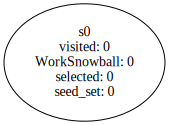

In [5]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("ieee2015", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
FinalSelection(state)

In [6]:
strategy.initial.seed_set @ metakey_title

[]

In [7]:
strategy.initial.visited @ metakey_title

[]

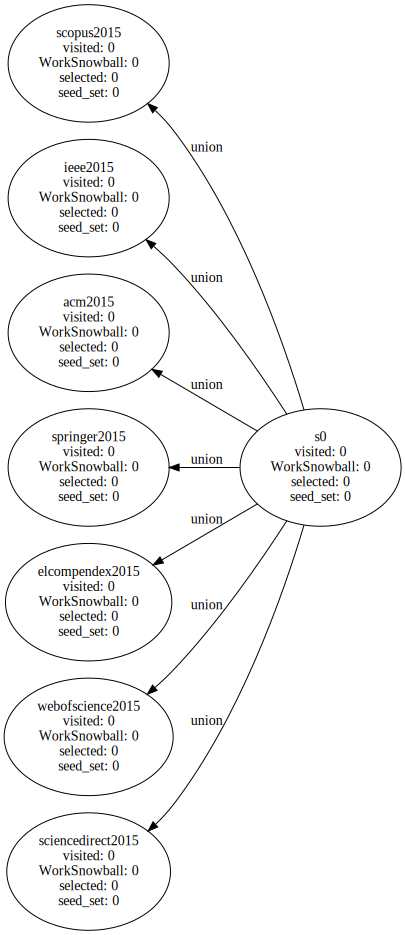

In [8]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus2015", "ieee2015", "acm2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015"], filter_function)
#strategy.initial.find("acm")
FinalSelection(strategy.initial)

In [9]:
strategy.initial.visited

set()

In [10]:
array = []

print ("--- Estratégia 1 (E1) ---")

name = "E1"
EP = len (strategy.initial.related) / len (strategy.initial.visited)
print ("Precision Seed Set: " + "%.2f" %(EP*100))

ER = len (strategy.initial.related) / 22
print ("Recall: " + "%.2f" %(ER*100))

FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.2f" %(FS*100))

PF = len (strategy.initial.final_selected)/len (strategy.initial.visited)
print ("Precision Seleção Final: " + "%.2f" %(PF*100))

RF = len (strategy.initial.final_selected)/ 22 
print ("Recall Seleção Final: " + "%.2f" %(RF*100))

FF = 2*((PF*RF)/(PF+RF))
print ("F-Measure Seleção Final: " + "%.2f" %(FF*100))

#array.append((name, EP, ER, FS))

--- Estratégia 1 (E1) ---


ZeroDivisionError: division by zero

In [ ]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

In [ ]:
array

## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

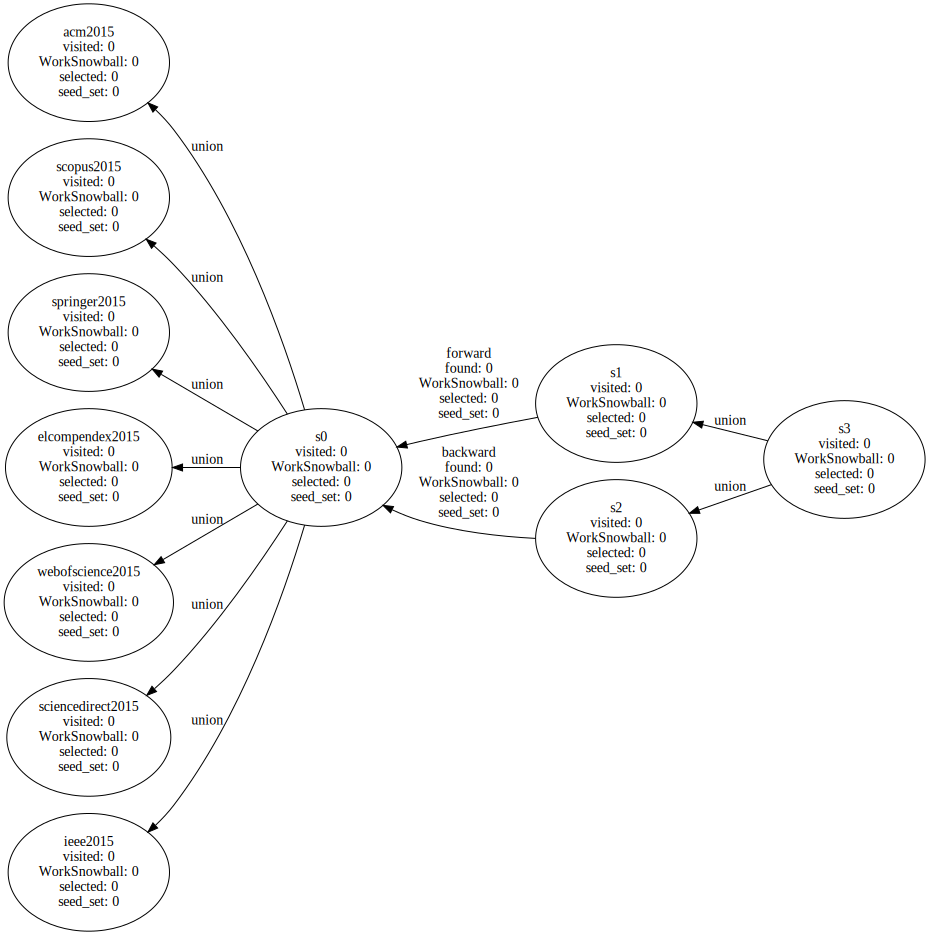

In [11]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm2015", "scopus2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015", "ieee2015"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

FinalSelection(state)

In [12]:
state.final_selected @ metakey

[]

In [13]:
state.find("sciencedirect2015").final_selected @ metakey_title

[]

### Resumo 

#### Resumo da Busca em DL

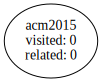

In [14]:
strategy.initial.find("acm2015")

In [15]:
# Visitados ACM
strategy.initial.find("acm2015").visited

set()

In [16]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("webofscience2015").related

set()

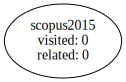

In [17]:
strategy.initial.find("scopus2015")

In [18]:
print("Visitados Scopus:")
strategy.initial.find("scopus2015").visited

Visitados Scopus:


set()

In [19]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus2015").related

Relacionados Scopus - encontrado no seed set:


set()

In [20]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm2015").visited & strategy.initial.find("scopus2015").visited

Artigo comum a ACM e Scopus:


set()

#### Resumo do Snowballing

In [21]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


0

In [22]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


set()

In [23]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s2").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


[]

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [24]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


set()

#### Relacionados - Seed Set

In [25]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


[]

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [26]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


set()

In [27]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


[]

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [28]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


[]

#### Relacionados - Encontrados Via Backward e Forward

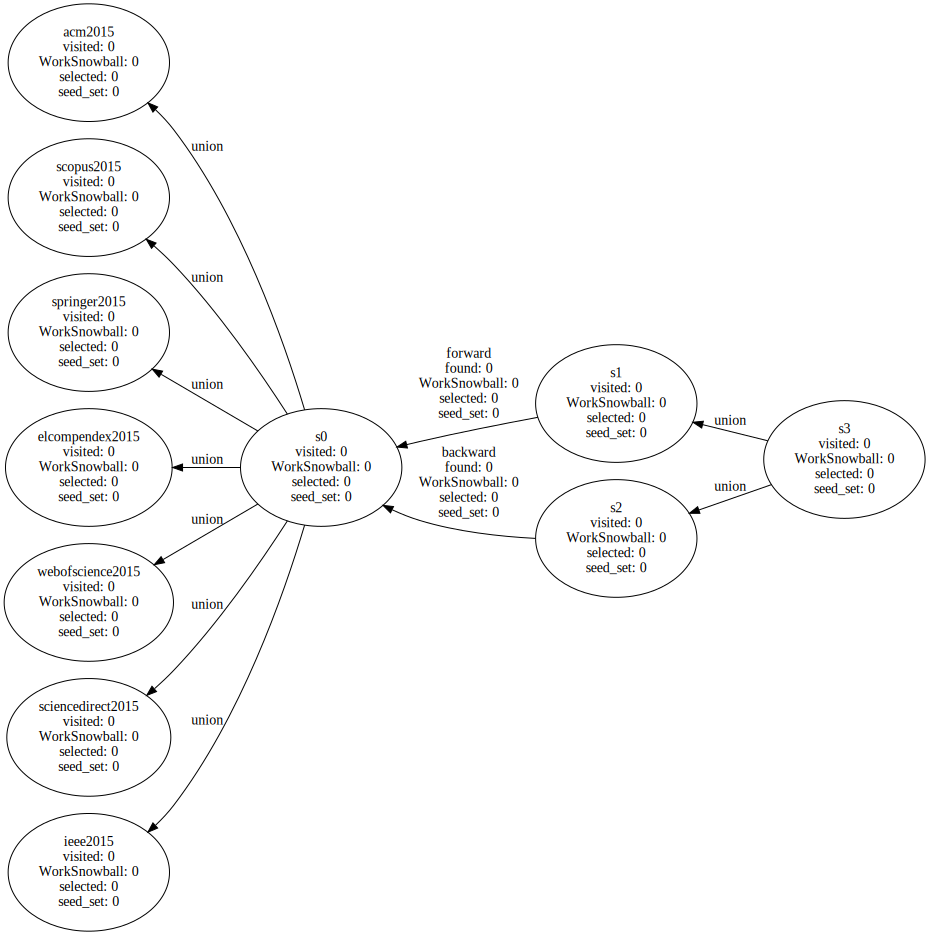

In [29]:
FinalSelection(state)

In [30]:
# Quantidade de artigo que existe em mais de uma biblioteca, após a união, no Estado S0, Ex, existe 1 artigo em acm e scopus.
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm2015").visited) + len(strategy.initial.find("scopus2015").visited) + len(strategy.initial.find("elcompendex2015").visited) + len(strategy.initial.find("springer2015").visited) + len(strategy.initial.find("webofscience2015").visited) + len(strategy.initial.find("sciencedirect2015").visited)) - len(state.find("s0").visited)

0

In [31]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[[], []]

In [32]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [33]:
strategy.forward??

In [34]:
duplicados(strategy, state)

0

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib_venn\_venn2.py:50: UserWarning: Both circles have zero area
  warnings.warn("Both circles have zero area")


<IPython.core.display.Javascript object>


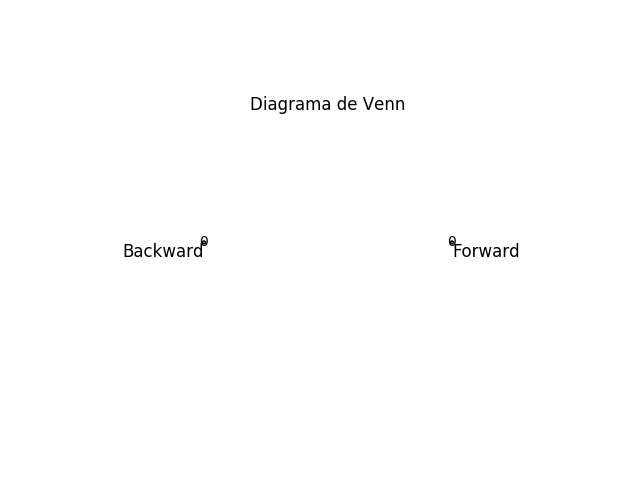

In [35]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [39]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward []
Forward []


In [40]:
state.find("s0").related @ metakey

[]

In [41]:
#x = v.get_patch_by_id('100')

In [42]:
#x.set_linestyle = "black"

In [43]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [44]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 



#### Execução de Forward em cada artigo relacionado do S1

In [45]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 



#### Resumo do Precision e Recall

In [46]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)
print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

#array.append((name, EP, ER, FS))


ZeroDivisionError: division by zero

In [47]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

UnboundLocalError: local variable 'accumulated_precision' referenced before assignment

In [48]:
df["state"]  + "\n" + df["operation"]

NameError: name 'df' is not defined

<IPython.core.display.Javascript object>


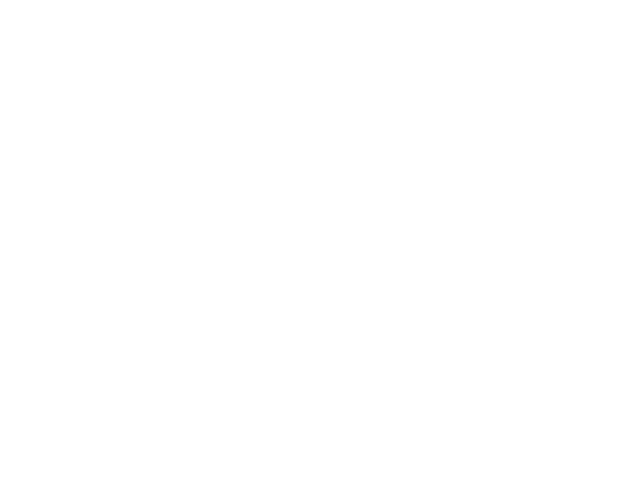

NameError: name 'df' is not defined

In [49]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
df['fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

<IPython.core.display.Javascript object>


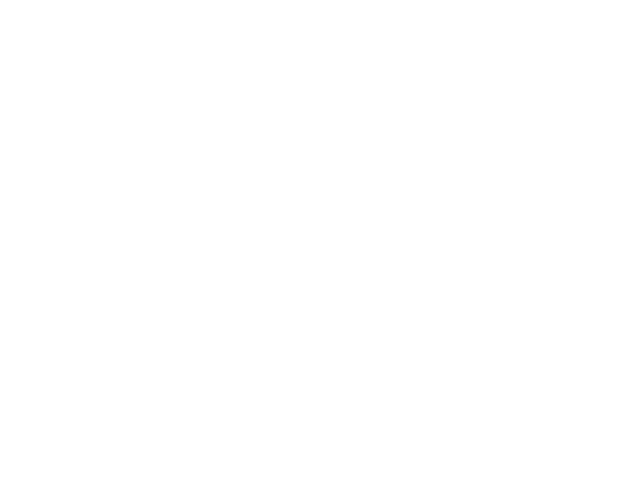

NameError: name 'df' is not defined

In [52]:
fig = plt.figure()
df['final_precision'].plot(legend=True)
df['final_recall'].plot(legend=True)
df['final_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Final By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

<IPython.core.display.Javascript object>


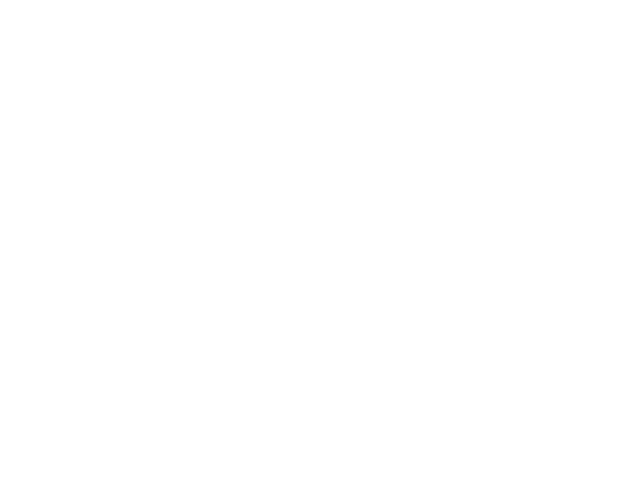

NameError: name 'df' is not defined

In [53]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
df['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Accumulated");
plt.tight_layout()

In [ ]:
fig = plt.figure()
df['final_accumulated_precision'].plot(legend=True)
df['final_accumulated_recall'].plot(legend=True)
df['final_accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Final Accumulated");
plt.tight_layout()

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

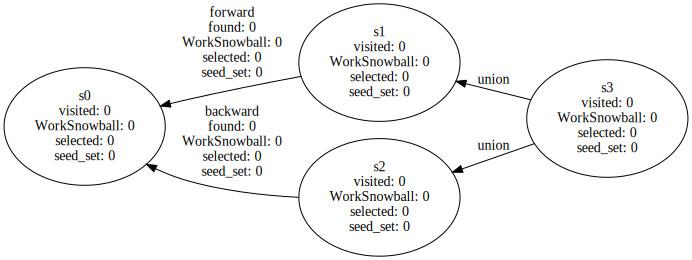

In [83]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
FinalSelection(state)

In [84]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

#array.append((name, EP, ER, FS))

Precision E3


ZeroDivisionError: division by zero

In [ ]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df


## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
FinalSelection(state)

In [ ]:
descreve_delta(strategy, state, "s2")


In [ ]:
texto = """backward becker2008a
- weber2005a 
- hierholzer1998a 
- debou1999a 
- liu2005a 
- yamamura1999a 
- cox1992a 
- grady1997a 
- biró1999a 
- mccoy1998a 
- dyba2005a 
- humphrey1989b 
- paulk1993a 
- chrissis2003a 
- zaijun2005a 
- peterson1995a 
- brodman1995a 
- akao1990a 
- pitterman2000a 
- pulford1996a 
- montoni2007a 
- yin2003a 
- isoiec2003a 
- zahran1998a 
- niazi2003a 
backward martins2008a
- arthur1993a 
- isoiec1998a 
- salo2005a 
- krasner1997a 
- kuvaja1994a 
- cmm2002a 
- isoiec1998c 
- isoiec1998b 
- emam1999a 
- pfleeger1994a 
- solingen1999a 
- paulk1993a 
- vertage1994a 
- martins2007b 
backward reiblein1997a
- kaplan1993a 
- miller1995a 
- trade1992a 
- hinley1997a 
- vlasveld1995a 
- deming1986a 
- group1997a 
- iso1994b 
- itil1989a 
- iso1994a 
- cmm1993a 
- humphrey1989a 
- isoies1997a 
- kaplan1996b 
backward albuquerque2009a
- birk2002a 
- stalhane2004a 
- prahalad1999a 
- softex2009a 
- boehm2000b 
- cmusei2006a 
- nollen2008a 
- salo2005b 
- wright2000a 
- isoiec2004a 
- lawrence2001a 
- reed2000a 
- cater2004a 
- dybå2003b 
- birk1998a 
- bardin1977a 
- hefner2001a 
- thompson2000a 
- kim1995a 
- isoiec2004b 
- alloui2000a 
- caivano2005a 
- mcnair1990a 
- kaplan2000a 
- adams1993a 
- komi2004a 
- martins2007b 
backward kaneko2011a
- kathuria2007a 
- isaca2005a 
- kaplan1992a 
- basili2009a 
- basili2007b 
- becker1999a 
- isaca2008a 
- ogc2002a 
- basili1992a 
- jaxa2012a 
- kowalczyk2010a 
backward guzmán2010a
- ebert2007a 
- mcgarry2002a 
- goethert2004a 
- kaplan2008a 
- chastek2009a 
- tuan2006a 
- basili2009b 
- el2007a 
- sei2006b 
- kojima2008a 
- mishra2008a 
- long2008a 
- watson2007a 
- kanji2007a 
- oliveira2009a 
- porter1979a 
- lamb1984a 
- isoiec2007a 
- asgarkhani2006a 
- harjumaa2008a 
- mcloone2007a 
- mehra2004a 
- kamel2009a 
- card2003a 
- neergaard2007a 
- basili2010a related
- kaplan2005a 
- gopal2005a 
- peng2007a 
- kahraman2007a 
- isoiec2004a 
- fahey2007a 
- kaplan2006a 
- trienekens2009a related
- dyba2005a 
- shull2006a 
- el2001a 
- qi2007a 
- issac2006a 
- isoiec2008a 
- kaplan1997a 
- kuppusamy2008a 
- capell2004a 
- goethert2003a 
backward wilkie2007a
- iso2006a 
- anacleto2004b 
- wilkie2005a 
- mcfeeley1996a 
- anacleto2004a 
- makinen2000a 
- caffery2004a 
- sei2004a 
- wilkie2004a 
- cspt2003a 
- institute2005a 
- chrissis2003a 
- ISOIEC2006a 
- caffery2005a 
- mcfall2003a 
- sei2005a 
- paulk1995a 
- cignoni1999a 
- team2007a 
- rout2001a 
backward plösch2011a
- shewhart1931a 
- isoiec2003b 
- simon2002a 
- venzin2003a 
- cmmi2006a 
- mcfeeley1996a 
- isoiec1998d 
- dion1993a"""

In [85]:
conjuntos = [set(x.split("-")[1:]) for x in texto.split("backward")[1:]]

In [86]:
conjuntos[0] & conjuntos[1]

{' paulk1993a \n'}

In [87]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

#array.append((name, EP, ER, FS))

Precision E4


ZeroDivisionError: division by zero

In [88]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

UnboundLocalError: local variable 'accumulated_precision' referenced before assignment

In [89]:
state.find("s0").related

set()

In [90]:
state.find("s2").related

set()

In [91]:
state.find("s0").visited

set()

In [92]:
strategy

In [93]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [94]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [95]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

set()

In [96]:
len(state.find("s1").delta_visited)

0

In [97]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

2

In [98]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

0

In [99]:
search_state = strategy.initial
search_state.related

set()

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

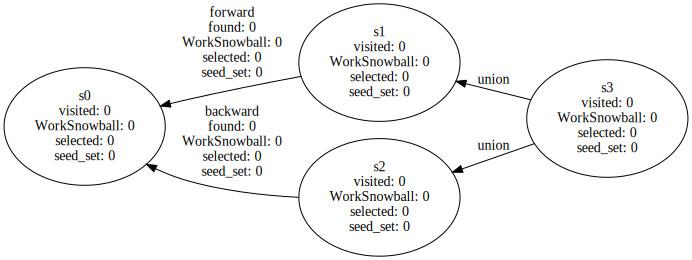

In [100]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.s2bbff2u()
FinalSelection(state)

In [101]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

#array.append((name, EP, ER, FS))

Precision E5


ZeroDivisionError: division by zero

In [ ]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

In [102]:
state.find("s0").related 

set()

In [103]:
state.find("s1").related 

set()

In [104]:
state.find("s3").related 

set()

In [105]:
sx, sy = state.previous[0]

sx.related & sy.related


set()

In [106]:
sx.name

's1'

In [107]:
sy.name

's2'

In [108]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[[], []]

In [109]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


[]

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

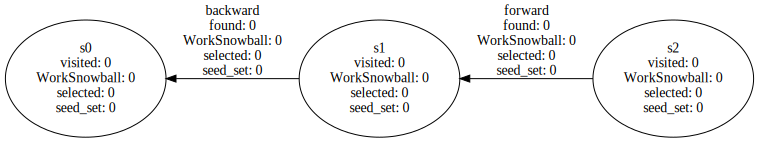

In [110]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.bbff()
FinalSelection(state)

In [111]:
strategy._repeat??

In [112]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

#array.append((name, EP, ER, FS))

Precision E6


ZeroDivisionError: division by zero

In [ ]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

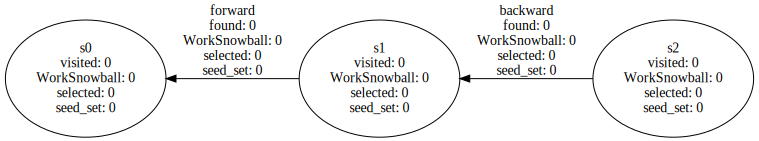

In [113]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.ffbb()
FinalSelection(state)

In [114]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

print ("Final Precision " + name)
FEP = len (state.final_selected) / len (state.visited)
print (FEP)
print ("Final Recall " + name)
FER = len (state.final_selected) / len (TOTAL)
print (FER)

print ("Final F-measure " + name)
FFS = 2*((FEP*FER)/(FEP+FER))
print (FFS)

#array.append((name, EP, ER, FS, FEP, FER, FFS))

Precision E7


ZeroDivisionError: division by zero

In [ ]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

# Análise das Estratégias

In [115]:
%matplotlib notebook
import pandas as pd

In [116]:
df = pd.DataFrame (array,columns = [
    'Estratégia', 'Related', 'Visited', 'Final Selected', 
    'Precision', 'Recall', 'F-Measure',
    'Final Precision', 'Final Recall', 'Final F-Measure'])
df.index = df['Estratégia']
df

,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,


In [117]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df.loc[:, df.columns.difference(exclude)].plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
df

In [118]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

# Individual

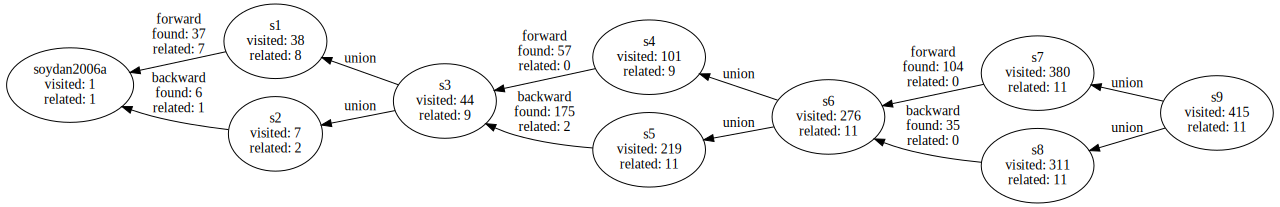

In [135]:
reload()
#NAME = "guzmán2010a"
NAME = "soydan2006a"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state

In [138]:
state.find("s2").delta_visited @ metakey_title

['liao2005a - A software process ontology and its application',
 'cmmi2002ab - Capability maturity model integration version 1.1 cmmism for software',
 'w3c2004c - Web Ontology Language Reference OWL',
 'carnegie2006a - cmmi appraisals',
 'carnegie2005a - List of published scampi appraisal results',
 'mendes2004a - Software engineering ontology: A development methodology']

In [139]:
state.find("s2").delta_related @ metakey_title

['liao2005a - A software process ontology and its application']

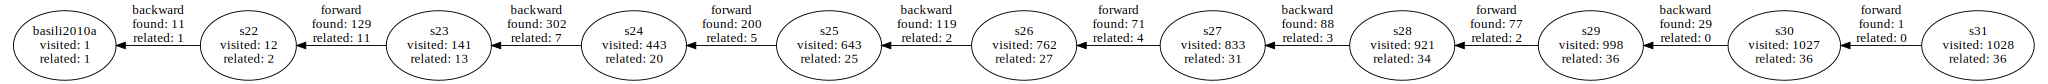

In [98]:
strategy.bfbf()